# Sunshine hours prediction regression model generation

This notebook provides a walkthrough on creating a 3-layer neural network based classification model to predict tomorrow's sunshine hours based on meteorological data from today. The data is obtained from [zenodo](https://doi.org/10.5281/zenodo.5071376). This is an example of a tabular data based regression model. Keras is used to create the neural network and the final model is converted and saved in ONNX format. This model is largely inspired by the [Introduction to Deep Learning](https://carpentries-incubator.github.io/deep-learning-intro/3-monitor-the-model.html) carpentries lesson.

### Load the dataset

In [1]:
import pandas as pd

data = pd.read_csv("https://zenodo.org/record/5071376/files/weather_prediction_dataset_light.csv?download=1")

### Prepare the data

As the target, the sunshine hours for the next day in the data-set will be used.
Therefore, we will remove the last data point as this has no target.
A tabular regression model will be trained which does not require time-based data, 
therefore DATE and MONTH can be removed 

In [44]:
X_data = data.drop(columns=['DATE', 'MONTH'])[:-1]
y_data = data.loc[1:]["BASEL_sunshine"]

### Training, validation, and test data split

In [54]:
from sklearn.model_selection import train_test_split

X_train, X_holdout, y_train, y_holdout = train_test_split(X_data, y_data, test_size=0.3, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_holdout, y_holdout, test_size=0.5, random_state=0)

### Build & Compile Keras Model

Two hidden layers are used along with a batch normalization layer

In [55]:
from tensorflow import keras

def sunshine_prediction_model():
    # Input layer
    inputs = keras.Input(shape=(X_data.shape[1],), name='input')

    # Dense layers
    layers_dense = keras.layers.BatchNormalization()(inputs)
    layers_dense = keras.layers.Dense(10, 'relu')(inputs)
    layers_dense = keras.layers.Dense(5, 'relu')(layers_dense)

    # Output layer
    outputs = keras.layers.Dense(1)(layers_dense)

    return keras.Model(inputs=inputs, outputs=outputs, name="sunshine_prediction_model")

model = sunshine_prediction_model()
model.summary()

Model: "sunshine_prediction_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 89)]              0         
                                                                 
 dense_18 (Dense)            (None, 10)                900       
                                                                 
 dense_19 (Dense)            (None, 5)                 55        
                                                                 
 dense_20 (Dense)            (None, 1)                 6         
                                                                 
Total params: 961
Trainable params: 961
Non-trainable params: 0
_________________________________________________________________


In [56]:
# Compile model
model.compile(optimizer='adam',
              loss='mse',
              metrics=[keras.metrics.RootMeanSquaredError()])

### Train the model

The model is trained on the training data with early stopping based on validation loss

In [57]:
from tensorflow.keras.callbacks import EarlyStopping

earlystopper = EarlyStopping(
    monitor='val_loss',
    patience=10
    )

In [58]:
history = model.fit(
    X_train, y_train,
    batch_size=64,
    epochs=200,
    validation_data=(X_val, y_val),
    callbacks=[earlystopper]
    )

Epoch 1/200
40/40 [==============================] - 1s 7ms/step - loss: 17.3122 - root_mean_squared_error: 4.1608 - val_loss: 14.8746 - val_root_mean_squared_error: 3.8568
Epoch 2/200
40/40 [==============================] - 0s 3ms/step - loss: 13.7668 - root_mean_squared_error: 3.7104 - val_loss: 13.9745 - val_root_mean_squared_error: 3.7382
Epoch 3/200
40/40 [==============================] - 0s 3ms/step - loss: 13.1181 - root_mean_squared_error: 3.6219 - val_loss: 13.3215 - val_root_mean_squared_error: 3.6499
Epoch 4/200
40/40 [==============================] - 0s 3ms/step - loss: 12.6284 - root_mean_squared_error: 3.5536 - val_loss: 12.9087 - val_root_mean_squared_error: 3.5929
Epoch 5/200
40/40 [==============================] - 0s 3ms/step - loss: 12.3896 - root_mean_squared_error: 3.5199 - val_loss: 12.6756 - val_root_mean_squared_error: 3.5603
Epoch 6/200
40/40 [==============================] - 0s 2ms/step - loss: 12.2504 - root_mean_squared_error: 3.5001 - val_loss: 12.3655 

### Test the model

In [59]:
y_train_predicted = model.predict(X_train)
y_test_predicted = model.predict(X_test)

18/18 [==============================] - 0s 1ms/step


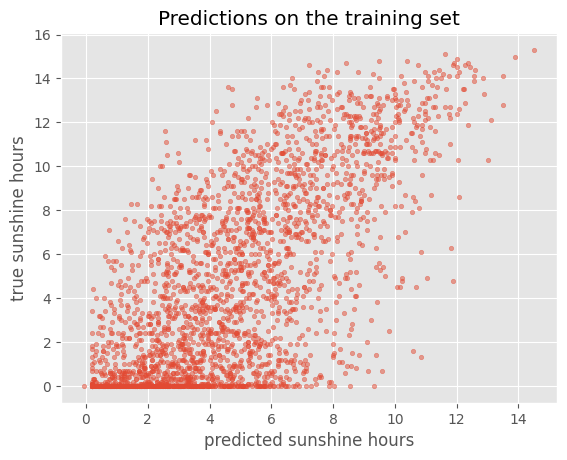

In [60]:
import matplotlib.pyplot as plt
# We define a function that we will reuse in this lesson
def plot_predictions(y_pred, y_true, title):
    plt.style.use('ggplot')  # optional, that's only to define a visual style
    plt.scatter(y_pred, y_true, s=10, alpha=0.5)
    plt.xlabel("predicted sunshine hours")
    plt.ylabel("true sunshine hours")
    plt.title(title)

plot_predictions(y_train_predicted, y_train, title='Predictions on the training set')

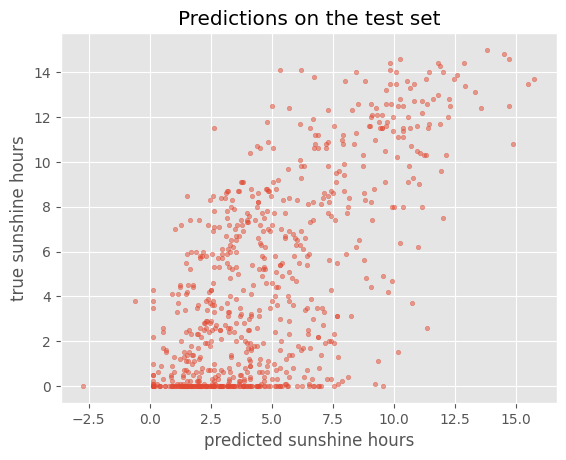

In [51]:
plot_predictions(y_test_predicted, y_test, title='Predictions on the test set')

In [63]:
# Compare with baseline RMSE
# Here we assume that today's sunshine hours will be the same for tomorrow
from sklearn.metrics import mean_squared_error

y_baseline_prediction = X_test['BASEL_sunshine']
rmse_baseline = mean_squared_error(y_test, y_baseline_prediction, squared=False)
test_metrics = model.evaluate(X_test, y_test, return_dict=True)
print('Baseline:', rmse_baseline)
print(f'Test RMSE: {test_metrics["root_mean_squared_error"]}')

18/18 [==============================] - 0s 2ms/step - loss: 10.6426 - root_mean_squared_error: 3.2623
Baseline: 3.9858188399396077
Test RMSE: 3.2623026371002197


### Convert to ONNX and save model

In [65]:
import tf2onnx

output_path = 'sunshine_hours_regression_model.onnx'
tf2onnx.convert.from_keras(model, opset=13, output_path=output_path)

2023-11-15 10:59:11.040958: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2023-11-15 10:59:11.041148: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-11-15 10:59:11.071681: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2023-11-15 10:59:11.071910: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session


(ir_version: 7
 producer_name: "tf2onnx"
 producer_version: "1.15.1 12a3ba"
 graph {
   node {
     input: "input"
     input: "sunshine_prediction_model/dense_18/MatMul/ReadVariableOp:0"
     output: "sunshine_prediction_model/dense_18/MatMul:0"
     name: "sunshine_prediction_model/dense_18/MatMul"
     op_type: "MatMul"
   }
   node {
     input: "sunshine_prediction_model/dense_18/MatMul:0"
     input: "sunshine_prediction_model/dense_18/BiasAdd/ReadVariableOp:0"
     output: "sunshine_prediction_model/dense_18/BiasAdd:0"
     name: "sunshine_prediction_model/dense_18/BiasAdd"
     op_type: "Add"
   }
   node {
     input: "sunshine_prediction_model/dense_18/BiasAdd:0"
     output: "sunshine_prediction_model/dense_18/Relu:0"
     name: "sunshine_prediction_model/dense_18/Relu"
     op_type: "Relu"
   }
   node {
     input: "sunshine_prediction_model/dense_18/Relu:0"
     input: "sunshine_prediction_model/dense_19/MatMul/ReadVariableOp:0"
     output: "sunshine_prediction_model/den